### Load Model

In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()


c:\Users\saleh\OneDrive\Documents\uni\Quest_Internship\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

#### Perplexity

In [17]:
import torch
import math

def calculate_perplexity(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt")  #return pt means to return pytorch tensors
    with torch.no_grad():  #to prevent carrying out unnecessary training functions
        outputs = model(**inputs, labels=inputs["input_ids"])  #for prediction
        loss = outputs.loss   #this is cross entropy loss
    return math.exp(loss.item())   #perpelixity=e ^ cross entropy loss

#different perplexity for different texts
text1 = "Apple released a new iPhone today, featuring better battery life and a titanium frame."
text2 = "In this paper, we derive the Lagrangian multipliers for a non-linear constrained optimization problem."
text3 = "To install TensorFlow, run pip install tensorflow in your terminal."

for text in [text1, text2, text3]:
    print(f"Text: {text}\nPerplexity: {calculate_perplexity(text, model, tokenizer)}\n")


Text: Apple released a new iPhone today, featuring better battery life and a titanium frame.
Perplexity: 38.48263277224266

Text: In this paper, we derive the Lagrangian multipliers for a non-linear constrained optimization problem.
Perplexity: 49.32356583348891

Text: To install TensorFlow, run pip install tensorflow in your terminal.
Perplexity: 16.321108164977097



#### BLEU, Rouge and BERTScore

In [10]:
input_prompt = "What is the capital of France?"
inputs = tokenizer(input_prompt, return_tensors="pt")
outputs = model.generate(
    **inputs,
    max_new_tokens=20,
    do_sample=False,
    temperature=0.7,
    top_p=0.9,
)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What is the capital of France?

The capital of France is Paris.

The capital of France is Paris.




Keeping do_sample=true can give very wierd and vague answers sometimes as well. 

| Parameter           | Meaning                                                                |
| ------------------- | ---------------------------------------------------------------------- |
| `max_new_tokens=20` | Limits generation to 20 new tokens max                                 |
| `do_sample=True`    | Enables random sampling (instead of greedy/argmax)                     |
| `temperature=0.7`   | Controls randomness; <1 → more focused, >1 → more diverse              |
| `top_p=0.9`         | Enables **nucleus sampling**: only sample from top 90% probable tokens |


In [19]:
import evaluate

bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

references = ["Paris is the capital of France."]  # ground truth
predictions = [generated_text]

bleu_result = bleu.compute(predictions=predictions, references=[references])
rouge_result = rouge.compute(predictions=predictions, references=references)

bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="en")

print("BLEU:", bleu_result["bleu"])
print("ROUGE-1:", rouge_result["rouge1"])
print("ROUGE-L:", rouge_result["rougeL"])

print("\nBERTScore Precision:", bertscore_result["precision"][0])
print("BERTScore Recall:", bertscore_result["recall"][0])
print("BERTScore F1:", bertscore_result["f1"][0])


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BLEU: 0.18493046910349434
ROUGE-1: 0.5
ROUGE-L: 0.4166666666666667

BERTScore Precision: 0.8658912777900696
BERTScore Recall: 0.8942316174507141
BERTScore F1: 0.8798332810401917


- BLEU gives a low score because it cares about order
- Rouge basically checks a bit more about how many of the original words were used, so its score is not as bad as BLEU
- BERTScore also checks semantics, so it gives an even better score

#### Hyperparameter Tuning
- For a pretrained model, hyper parameter tuning is on variables like temperature, do_sample etc. 
- Testing different values for different kinds of expected responses(e.g deterministic, creative)

##### Trying to get a deterministic output

In [42]:
input_prompt = "In which continent is Pakistan located?"
inputs = tokenizer(input_prompt, return_tensors="pt")
outputs = model.generate(
    **inputs,
    max_new_tokens=15,  
    do_sample=False,
    num_beams=5, 
    early_stopping=True,
    no_repeat_ngram_size=2
)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In which continent is Pakistan located?

Pakistan is located in the south-east of the country. It


##### Creative Output

In [52]:
input_prompt = "What advice would a cat give to a human?"
inputs = tokenizer(input_prompt, return_tensors="pt")
outputs = model.generate(
    **inputs,
    max_new_tokens=80,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What advice would a cat give to a human?

"I'm not saying that cats are good for you. They're not. But there are some things that you have to do when you're with a cat, and there are some things that you have to do when you're not with a cat, and then you have to be careful."

He also said that cat owners who are concerned about the safety of their pets are encouraged


Gpt 2 is better at creative responses

### Export To ONNX

In [ ]:
import torch

dummy_input = tokenizer("Hello, world!", return_tensors="pt")["input_ids"]
#this is done to make sure that the model runs the input at least once to understand the general flow

torch.onnx.export(
    model,
    dummy_input,
    "gpt2.onnx",
    input_names=["input_ids"],
    output_names=["logits"], 
    #allows for different input sizes
    #batch_size: no of prompts in one forward pass
    #sequence_length: no of tokens in each prompt
    dynamic_axes={"input_ids": {0: "batch_size", 1: "sequence_length"},
                  "logits": {0: "batch_size", 1: "sequence_length"}},
    opset_version=14,
)


In [57]:
import torch
import numpy as np
import onnxruntime as ort

# Load ONNX model
ort_session = ort.InferenceSession("gpt2.onnx")

def onnx_inference(text):
    inputs = tokenizer(text, return_tensors="np")
    ort_inputs = {ort_session.get_inputs()[0].name: inputs["input_ids"]}
    ort_outs = ort_session.run(None, ort_inputs)
    logits = ort_outs[0]  # shape: (batch_size, seq_len, vocab_size)
    return logits

def logits_to_text(logits):
    # Convert logits to PyTorch tensor for convenience
    logits_tensor = torch.tensor(logits)

    # Take the last token's logits for generation
    last_token_logits = logits_tensor[0, -1, :]

    # Apply softmax to get probabilities
    probs = torch.softmax(last_token_logits, dim=0)

    # Pick the token with highest probability (greedy decoding)
    predicted_token_id = torch.argmax(probs).item()

    # Decode predicted token id back to text
    predicted_token = tokenizer.decode([predicted_token_id])

    return predicted_token

# Example usage:
input_text = "The cat sat on the"
logits = onnx_inference(input_text)
predicted_token = logits_to_text(logits)

print(f"Input text: {input_text}")
print(f"Next predicted token: {predicted_token}")


Input text: The cat sat on the
Next predicted token:  floor


### Compare ONNX and PyTorch

In [63]:
import time
import torch

model.to("cpu")

def pytorch_inference(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.logits

# Warm-up (optional, for fair timing)
pytorch_inference("She was sitting on the")

start = time.time()
logits_pt = pytorch_inference("She was sitting on the")
end = time.time()
print(f"PyTorch inference time: {end - start:.4f} seconds")


PyTorch inference time: 0.0949 seconds


In [64]:
import onnxruntime as ort
import numpy as np

ort_session = ort.InferenceSession("gpt2.onnx")

def onnx_inference(text):
    inputs = tokenizer(text, return_tensors="np")
    ort_inputs = {ort_session.get_inputs()[0].name: inputs["input_ids"]}
    ort_outs = ort_session.run(None, ort_inputs)
    return ort_outs[0]

# Warm-up
onnx_inference("She was sitting on the")

start = time.time()
logits_onnx = onnx_inference("She was sitting on the")
end = time.time()
print(f"ONNX Runtime inference time: {end - start:.4f} seconds")


ONNX Runtime inference time: 0.1280 seconds


Average PyTorch inference time over 5 runs: 0.4199 s
Average ONNX Runtime inference time over 5 runs: 0.0544 s


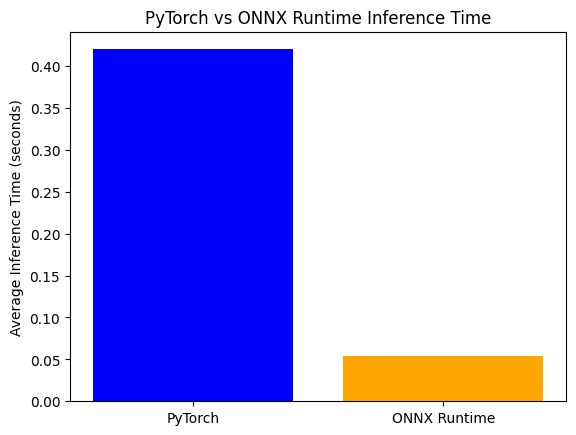

In [65]:
import time
import torch
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt

model.to("cpu")
ort_session = ort.InferenceSession("gpt2.onnx")

def pytorch_inference(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.logits

def onnx_inference(text):
    inputs = tokenizer(text, return_tensors="np")
    ort_inputs = {ort_session.get_inputs()[0].name: inputs["input_ids"]}
    ort_outs = ort_session.run(None, ort_inputs)
    return ort_outs[0]

input_text = "She was sitting on the"
num_trials = 5

# Warm-up
pytorch_inference(input_text)
onnx_inference(input_text)

# Measure PyTorch times
pt_times = []
for _ in range(num_trials):
    start = time.time()
    pytorch_inference(input_text)
    end = time.time()
    pt_times.append(end - start)

# Measure ONNX Runtime times
onnx_times = []
for _ in range(num_trials):
    start = time.time()
    onnx_inference(input_text)
    end = time.time()
    onnx_times.append(end - start)

# Average times
avg_pt = sum(pt_times) / num_trials
avg_onnx = sum(onnx_times) / num_trials

print(f"Average PyTorch inference time over {num_trials} runs: {avg_pt:.4f} s")
print(f"Average ONNX Runtime inference time over {num_trials} runs: {avg_onnx:.4f} s")

# Plotting
plt.bar(["PyTorch", "ONNX Runtime"], [avg_pt, avg_onnx], color=["blue", "orange"])
plt.ylabel("Average Inference Time (seconds)")
plt.title("PyTorch vs ONNX Runtime Inference Time")
plt.show()
